In [ ]:
#The required libraries
 #from IPython import get_ipython
 #from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler


In [ ]:
#from xgboost import XGBRegressor
#wasn't able to use xgboost as there is some issue clash between versions of
#sklearn and xgboost. Instead used Gradient boosting model

In [ ]:
# Downloading the Natural Language Toolkit Data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:

# Dataset Loading
df = pd.read_csv('Reviews.csv')
df = df.head(150000)    #As this is a Large Dataset Hardware might take forever to train that's why split as per requirement
df = df.dropna(subset=['Text', 'Score'])  # Ensure text and ratings are not null


In [ ]:
#Text Processing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower().strip() # Lowercase and strip whitespace
    text = re.sub(r'http\S+|www\S+', '', text)# Removes URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)# Removes special characters and numbers
    words = word_tokenize(text) # Tokenizing
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) # joins the words back to string

#applying it in the Text column
df['Processed_Text'] = df['Text'].apply(preprocess_text)


In [ ]:
#Feature Engineering
# TF-IDF Vectorization for Text
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))  # Include bigrams
tfidf_matrix = vectorizer.fit_transform(df['Processed_Text'])

# Additional Metadata Features
metadata_features = df[['HelpfulnessNumerator', 'HelpfulnessDenominator']].fillna(0)
metadata_features['Helpfulness_Ratio'] = metadata_features['HelpfulnessNumerator'] / (
    metadata_features['HelpfulnessDenominator'] + 1e-9

metadata_features['Review_Length'] = df['Text'].apply(len)
metadata_features['Word_Count'] = df['Text'].apply(lambda x: len(x.split()))

# Normalizing Numeric Features
scaler = StandardScaler()
metadata_features_scaled = scaler.fit_transform(metadata_features)

# Combine all features
X = np.hstack([tfidf_matrix.toarray(), metadata_features_scaled])
y = df['Score']

In [ ]:
#Model Training and Optimization
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training Gradient Boosting model with GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model selection after cross validation
best_model = grid_search.best_estimator_


In [ ]:
#test set predictiom
y_pred = best_model.predict(X_test)

In [ ]:
# Mean square and R^2
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 1.0021241653065809
R-squared: 0.41358611073647855


<ipython-input-36-89dab2a50504>:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance[sorted_idx], y=np.array(feature_names)[sorted_idx], palette='viridis')


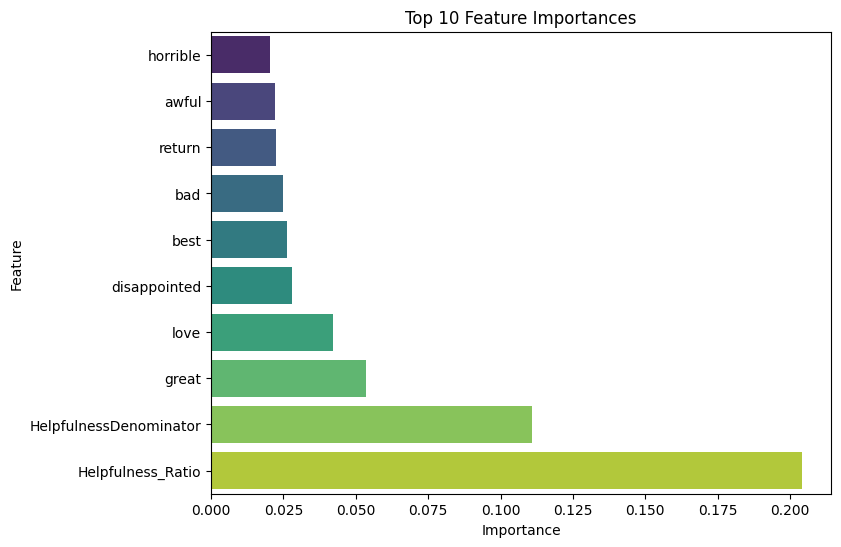

<ipython-input-36-89dab2a50504>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Sentiment', y='Score', data=df, palette='Set2')


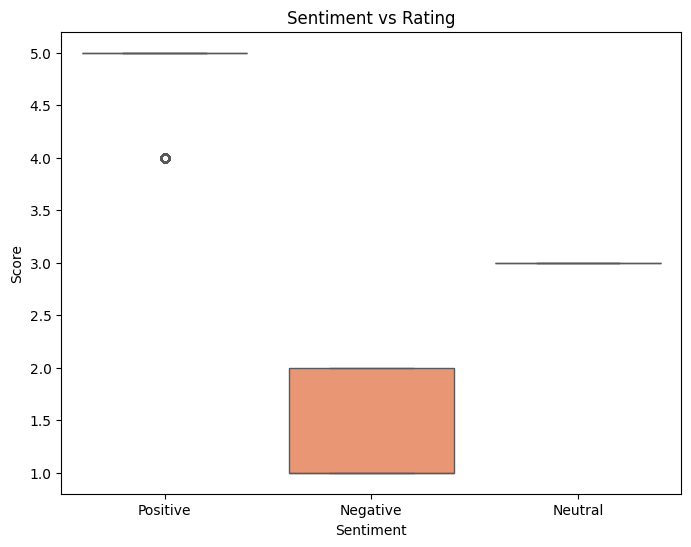

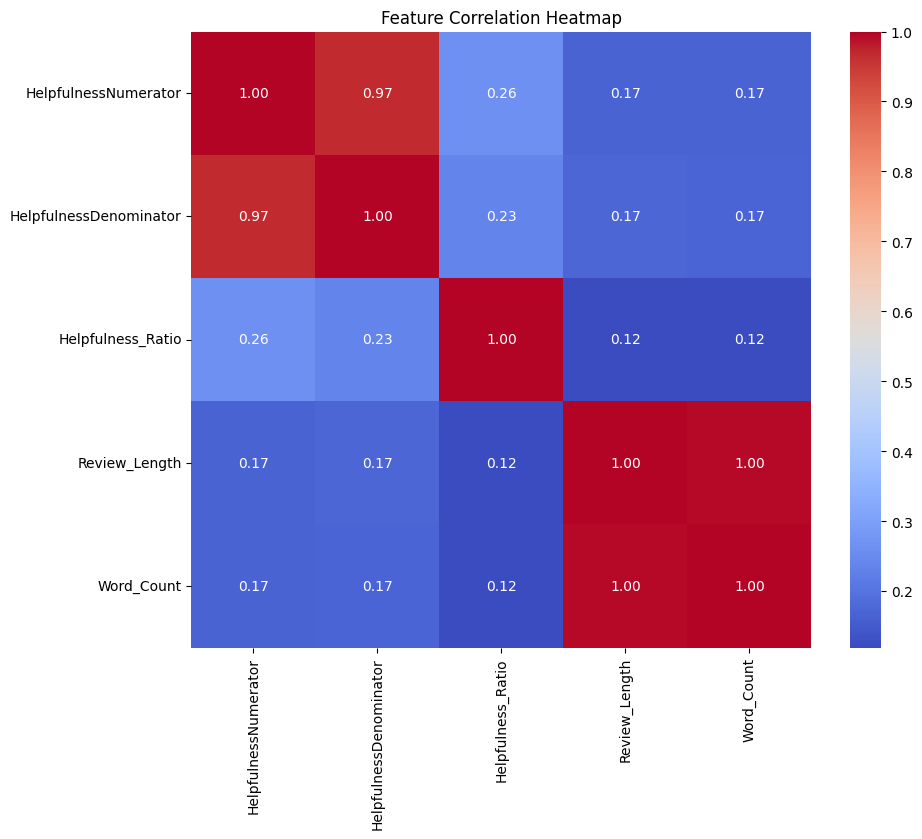

In [ ]:
#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sentiment Score Distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(df['Sentiment_Score'], bins=20, kde=True, color='skyblue')
    plt.title('Distribution of Sentiment Scores')
    plt.xlabel('Sentiment Score')
    plt.ylabel('Frequency')
    plt.show()



# 3. Feature Importance
if hasattr(best_model, 'feature_importances_'):
    feature_names = vectorizer.get_feature_names_out().tolist() + metadata_features.columns.tolist()
    feature_importance = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[-10:]

    plt.figure(figsize=(8, 6))
    sns.barplot(x=feature_importance[sorted_idx], y=np.array(feature_names)[sorted_idx], palette='viridis')
    plt.title('Top 10 Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# 4. Sentiment vs Rating Visualization (Box Plot)
def categorize_sentiment(score):
    if score > 3:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    else:
        return 'Negative'

df['Sentiment'] = df['Score'].apply(categorize_sentiment)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Sentiment', y='Score', data=df, palette='Set2')
plt.title('Sentiment vs Rating')
plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.show()

# 5. Feature Correlation Heatmap
correlation_data = metadata_features.copy()
if 'Sentiment_Score' in df.columns:
    correlation_data['Sentiment_Score'] = df['Sentiment_Score']

correlation_matrix = correlation_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()
